In [6]:
import numpy as np
import os
from pathlib import Path
from typing import List, Tuple
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence
from scipy.spatial import cKDTree # Aunque ya no la usaremos para el muestreo directo, la mantengo si la usas en otro lado
import random

# --- Constantes Clave ---
DESIRED_NUM_POINTS = 16384 # El número fijo de puntos que tu modelo espera
INPUT_DIM = 3              # Dimensión de los puntos (x, y, z)
NUM_CLASSES = 9            # Número de clases de segmentación
BATCH_SIZE = 16            # Tamaño del batch

# Mapeo de categorías de etiquetas (sin cambios)
category_mapping = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55], # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14], # Object
    2: [7, 22, 9, 26, 11, 21], # Road
    3: [48, 47, 1, 19, 46, 10, 25], # Sign
    4: [23, 3, 24, 31, 2], # Terrain 
    5: [51, 50, 5, 18], # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17], # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63], # Vehicle
    8: [8, 56, 0, 53, 54], # Void (Clase para puntos rellenos/vacíos)
}

# --- Funciones de Utilidad de Carga de Datos ---

# Esta función `filter_points_within_radius` se mantiene, aunque su lógica
# ahora se incorpora directamente en `load_bin_file_and_sample`.
def filter_points_within_radius(points: np.ndarray, radius: float = 25.0) -> np.ndarray:
    """Filtra puntos dentro de un radio dado desde el origen."""
    distances = np.linalg.norm(points, axis=1) 
    mask = distances <= radius  
    return points[mask]  

def load_bin_file_and_sample(bin_path: str, num_points_desired: int = DESIRED_NUM_POINTS, radius: float = 25.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Carga un archivo .bin, filtra puntos dentro de un radio,
    y luego muestrea aleatoriamente o rellena (pads) para obtener
    exactamente `num_points_desired` puntos.
    Devuelve los puntos seleccionados y sus índices correspondientes del archivo ORIGINAL.
    """
    points_full = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3] 

    # 1. Filtrar puntos por distancia
    distances = np.linalg.norm(points_full, axis=1)
    mask_radius = distances <= radius
    points_filtered_by_radius = points_full[mask_radius]
    original_indices_within_radius = np.where(mask_radius)[0]

    num_available_after_filter = points_filtered_by_radius.shape[0]

    selected_points = points_filtered_by_radius
    selected_original_indices = original_indices_within_radius

    if num_available_after_filter > num_points_desired:
        # 2. Si hay más puntos de los deseados, muestrear aleatoriamente.
        # `replace=False` asegura que los puntos sean únicos.
        sampled_indices_in_filtered = np.random.choice(
            num_available_after_filter,
            num_points_desired,
            replace=False
        )
        selected_points = points_filtered_by_radius[sampled_indices_in_filtered]
        selected_original_indices = original_indices_within_radius[sampled_indices_in_filtered]

    elif num_available_after_filter < num_points_desired:
        # 3. Si hay menos puntos de los deseados, rellenar (pad).
        num_padding = num_points_desired - num_available_after_filter
        
        # Puntos de padding (coordenadas cero)
        padding_points = np.zeros((num_padding, INPUT_DIM), dtype=points_full.dtype)
        
        # Índices de padding (puedes usar un valor especial o simplemente ceros si no se usan más tarde)
        # Para las etiquetas, usaremos la clase 'Void' (8)
        
        selected_points = np.vstack((points_filtered_by_radius, padding_points))
        selected_original_indices = np.hstack((original_indices_within_radius, np.full(num_padding, -1, dtype=int))) # -1 para indicar padding
        # Nota: El -1 en los índices originales no se usará para labels[indices] porque las etiquetas se rellenan después.
        # Es solo para mantener la coherencia si el índice original es necesario en otros sitios.

    # Si num_available_after_filter == num_points_desired, no se hace nada y se devuelve tal cual.

    return selected_points, selected_original_indices


label_to_category = {label: cat for cat, labels in category_mapping.items() for label in labels}

def map_labels(labels: np.ndarray) -> np.ndarray:
    """Mapea las etiquetas originales a las categorías definidas."""
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_label_file(label_path: str, indices_from_original_file: np.ndarray) -> np.ndarray:
    """
    Carga las etiquetas de un archivo .label y las mapea a las categorías.
    Usa los índices originales de los puntos para seleccionar las etiquetas correctas.
    Los índices que son -1 (padding) se mapearán a la clase 'Void' (8).
    """
    labels_full = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF 
    
    # Crea un array para las etiquetas resultantes con el tamaño deseado
    mapped_labels = np.full(indices_from_original_file.shape, 8, dtype=np.uint8) # Inicializa con la clase 'Void'
    
    # Selecciona solo los índices válidos (no -1)
    valid_indices_mask = indices_from_original_file != -1
    valid_original_indices = indices_from_original_file[valid_indices_mask]
    
    # Mapea las etiquetas para los puntos reales
    if len(valid_original_indices) > 0:
        mapped_labels[valid_indices_mask] = map_labels(labels_full[valid_original_indices])
    
    return mapped_labels

def get_file_paths(data_dir: str) -> List[str]:
    """Obtiene las rutas de los archivos en un directorio y las ordena."""
    return sorted([str(f) for f in Path(data_dir).glob("*.*")])

# --- Clase del Generador de Nubes de Puntos ---
# Este generador se simplifica enormemente porque `load_bin_file_and_sample`
# ya se encarga de dar los puntos con el tamaño correcto.

class PointCloudGenerator(Sequence):
    def __init__(self, bin_files: List[str], label_files: List[str], num_points: int, batch_size: int = 32):
        self.bin_files = bin_files
        self.label_files = label_files
        self.num_points = num_points # Esto será DESIRED_NUM_POINTS (16384)
        self.batch_size = batch_size
        self.on_epoch_end() # Llama para mezclar inicialmente los archivos

    def __len__(self):
        """Número total de batches por epoch."""
        return len(self.bin_files) // self.batch_size

    def __getitem__(self, idx):
        """Genera un batch de datos (puntos y etiquetas)."""
        batch_bin_files = self.bin_files[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_label_files = self.label_files[idx * self.batch_size : (idx + 1) * self.batch_size]

        x_batch, y_batch = [], []

        for bin_file, label_file in zip(batch_bin_files, batch_label_files):
            # Esta función ahora devuelve exactamente num_points_desired o menos si el archivo no tiene puntos,
            # pero ya rellena si es necesario para el tamaño fijo.
            points, original_indices = load_bin_file_and_sample(bin_file, self.num_points)
            labels = load_label_file(label_file, original_indices) # Esta función maneja los índices de padding

            x_batch.append(points)
            y_batch.append(labels)

        return np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.uint8)

    def on_epoch_end(self):
        """Mezcla los datos al final de cada epoch para un mejor entrenamiento."""
        temp = list(zip(self.bin_files, self.label_files))
        random.shuffle(temp)
        self.bin_files, self.label_files = zip(*temp)


# --- Rutas de Archivos de Datos ---
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"
x_val_path = "/home/fmartinez/datasets/goose/lidar/val"
y_val_path = "/home/fmartinez/datasets/goose/labels/val"
x_test_path = "/home/fmartinez/datasets_val/lidar/val" 
y_test_path = "/home/fmartinez/datasets_val/labels/val" 

x_train_files = get_file_paths(x_train_path)
y_train_files = get_file_paths(y_train_path)
x_val_files = get_file_paths(x_val_path)
y_val_files = get_file_paths(y_val_path)
x_test_files = get_file_paths(x_test_path)
y_test_files = get_file_paths(y_test_path)

# --- Inicialización de Generadores ---
# Asegúrate de usar DESIRED_NUM_POINTS aquí
# Nota: el parámetro `mode` ya no es necesario en PointCloudGenerator
# porque la lógica de muestreo está unificada en `load_bin_file_and_sample`.
train_generator = PointCloudGenerator(x_train_files, y_train_files, num_points=DESIRED_NUM_POINTS, batch_size=BATCH_SIZE)
val_generator = PointCloudGenerator(x_val_files, y_val_files, num_points=DESIRED_NUM_POINTS, batch_size=BATCH_SIZE)
test_generator = PointCloudGenerator(x_test_files, y_test_files, num_points=DESIRED_NUM_POINTS, batch_size=BATCH_SIZE)


# --- Definición del Modelo PointNet (sin cambios, ya estaba bien con DESIRED_NUM_POINTS) ---
def tnet(inputs, num_features):
    x = layers.Conv1D(64, 1, activation='relu', padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(num_features * num_features, kernel_initializer='zeros',
                     bias_initializer=tf.keras.initializers.Constant(tf.eye(num_features).numpy().flatten()))(x)
    transform_matrix = layers.Reshape((num_features, num_features))(x)

    def transform_points(inputs_and_matrix):
        inputs_tensor, matrix_tensor = inputs_and_matrix
        return tf.matmul(inputs_tensor, matrix_tensor)

    transformed_inputs = layers.Lambda(transform_points)([inputs, transform_matrix])
    transformed_inputs = layers.Lambda(lambda t: tf.ensure_shape(t, (None, DESIRED_NUM_POINTS, num_features)))(transformed_inputs)

    return transformed_inputs

def build_pointnet(num_classes: int, input_dim: int = 3, max_points: int = DESIRED_NUM_POINTS) -> Model:
    inputs = tf.keras.Input(shape=(max_points, input_dim)) 

    x = tnet(inputs, input_dim)

    x = layers.Conv1D(64, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = tnet(x, 64)

    x = layers.Conv1D(1024, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)

    global_features = layers.GlobalMaxPooling1D()(x)
    global_features = layers.Lambda(lambda t: tf.expand_dims(t, axis=1))(global_features)
    global_features = layers.Lambda(lambda t: tf.repeat(t, repeats=DESIRED_NUM_POINTS, axis=1))(global_features)

    x = layers.Lambda(lambda t: tf.ensure_shape(t, (None, max_points, 1024)))(x)

    x = layers.concatenate([x, global_features], axis=-1)

    x = layers.Conv1D(512, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(256, 1, activation='relu', padding="same")(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv1D(num_classes, 1, activation='softmax')(x)

    return Model(inputs, outputs)

# --- Métricas y Función de Pérdida Personalizadas (sin cambios) ---
class MeanIoUWrapper(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="mean_iou_wrapper", **kwargs):
        super(MeanIoUWrapper, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        self.metric.update_state(y_true, y_pred_labels)

    def result(self):
        return self.metric.result()

    def reset_state(self):
        self.metric.reset_state()

class MeanIoUWrapper_2(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="mean_iou_wrapper_2", **kwargs): 
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        self.metric.update_state(y_true, y_pred_labels, sample_weight)

    def result(self):
        return self.metric.result()

    def reset_state(self):
        self.metric.reset_state()


class_weights = {0: 1.3756800728474192, 1: 11.540744634253176, 2: 14.010762980452215, 3: 18.564527493588116, 4: 1.0714398416315722, 5: 0.4806517192715152, 6: 0.20640943202058679, 7: 6.540442855724357, 8: 20.108312727050706}
class_weight_tensor = tf.constant([class_weights[i] for i in range(NUM_CLASSES)], dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    sample_weights = tf.gather(class_weight_tensor, y_true) 
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * sample_weights  

# --- Compilación y Entrenamiento del Modelo ---
model = build_pointnet(num_classes=NUM_CLASSES, input_dim=INPUT_DIM, max_points=DESIRED_NUM_POINTS)
mean_iou_wrapper = MeanIoUWrapper(num_classes=NUM_CLASSES) 
optimizer = tf.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = optimizer,
    loss=weighted_loss,
    metrics=["accuracy", mean_iou_wrapper]
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16384, 3)]   0           []                               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 16384, 64)    256         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 16384, 64)   256         ['conv1d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_27 (Conv1D)             (None, 16384, 128)   8320        ['batch_normalization_32[0]

In [7]:
print(f"\nIniciando entrenamiento con {DESIRED_NUM_POINTS} puntos por muestra (muestreo aleatorio en radio) y batch_size={BATCH_SIZE}")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=1
)


Iniciando entrenamiento con 16384 puntos por muestra (muestreo aleatorio en radio) y batch_size=16
Epoch 1/30
422/422 [==============================] - 260s 597ms/step - loss: 1.9907 - accuracy: 0.2157 - mean_iou_wrapper: 0.0753 - val_loss: 1.9496 - val_accuracy: 0.2336 - val_mean_iou_wrapper: 0.0994
Epoch 2/30
422/422 [==============================] - 251s 594ms/step - loss: 1.7856 - accuracy: 0.3079 - mean_iou_wrapper: 0.1088 - val_loss: 1.8922 - val_accuracy: 0.4790 - val_mean_iou_wrapper: 0.1610
Epoch 3/30
422/422 [==============================] - 250s 592ms/step - loss: 1.7183 - accuracy: 0.3276 - mean_iou_wrapper: 0.1214 - val_loss: 1.9708 - val_accuracy: 0.4752 - val_mean_iou_wrapper: 0.1421
Epoch 4/30
422/422 [==============================] - 249s 589ms/step - loss: 1.6590 - accuracy: 0.3779 - mean_iou_wrapper: 0.1457 - val_loss: 2.3902 - val_accuracy: 0.2652 - val_mean_iou_wrapper: 0.1445
Epoch 5/30
422/422 [==============================] - 249s 589ms/step - loss: 1.5891

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Inferencia sobre el conjunto de prueba
all_preds, all_labels = [], []

for x_batch, y_batch in tqdm(test_generator, desc="Evaluando"):
    preds = model.predict(x_batch, verbose=0)
    preds_labels = np.argmax(preds, axis=-1)
    all_preds.append(preds_labels.reshape(-1))
    all_labels.append(y_batch.reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Accuracy global
accuracy = np.mean(all_preds == all_labels)

# Matriz de confusión
conf_mat = confusion_matrix(all_labels, all_preds, labels=np.arange(NUM_CLASSES))

# IoU
intersection = np.diag(conf_mat)
union = conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - intersection
iou_per_class = intersection / np.maximum(union, 1e-6)
miou = np.mean(iou_per_class)

# Precision por clase: TP / (TP + FP)
tp = np.diag(conf_mat)
fp = conf_mat.sum(axis=0) - tp
precision_per_class = tp / np.maximum(tp + fp, 1e-6)

# Accuracy por clase (Recall): TP / (TP + FN)
fn = conf_mat.sum(axis=1) - tp
accuracy_per_class = tp / np.maximum(tp + fn, 1e-6)

# Mostrar resultados
print(f"\nAccuracy global: {accuracy:.4f}")
print(f"Mean IoU (mIoU): {miou:.4f}")
print("\nClase |  IoU   | Prec.  | Acc.")
print("-" * 32)
for i in range(NUM_CLASSES):
    print(f"{i:5d} | {iou_per_class[i]:.4f} | {precision_per_class[i]:.4f} | {accuracy_per_class[i]:.4f}")


Evaluando: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Accuracy global: 0.4796
Mean IoU (mIoU): 0.1943

Clase |  IoU   | Prec.  | Acc.
--------------------------------
    0 | 0.1777 | 0.2215 | 0.4736
    1 | 0.0286 | 0.0329 | 0.1825
    2 | 0.0911 | 0.0948 | 0.7038
    3 | 0.0458 | 0.0488 | 0.4318
    4 | 0.3102 | 0.4903 | 0.4578
    5 | 0.4095 | 0.6645 | 0.5163
    6 | 0.4519 | 0.9042 | 0.4746
    7 | 0.1337 | 0.2416 | 0.2303
    8 | 0.1001 | 0.1015 | 0.8779


In [11]:
print(f"Clase 8 - TP: {tp[8]}, FP: {fp[8]}, FN: {fn[8]}")


Clase 8 - TP: 71324, FP: 631304, FN: 9923


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define color map for 3 categories
color_map = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

# Function to plot the confusion matrix in percentage
def plot_confusion_matrix_percentage(y_val, predicted_labels, num_classes=9):
    y_true = y_val.flatten()
    y_pred = predicted_labels.flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Convert to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Avoid NaNs due to division by zero

    class_labels = {
        0: "Construction",  # Gris
        1: "Object",  # Naranja
        2: "Road",  # Azul
        3: "Sign",  # Rojo
        4: "Terrain",  # Marrón
        5: "Drivable Vegetation",  # Verde claro
        6: "Non Drivable Vegetation",  # Verde oscuro
        7: "Vehicle",  # Amarillo
        8: "Void"  # Negro
    }
    
    class_names = [class_labels[i] for i in range(num_classes)]

    unique_classes, counts = np.unique(y_val.flatten(), return_counts=True)
    print("Distribución de clases reales:")
    for cls, count in zip(unique_classes, counts):
        print(f"Clase {cls}: {count} puntos")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=100)

    plt.xlabel("Predicted Classes")
    plt.ylabel("Ground Truth Classes")
    plt.title("Confusion Matrix - PointNet (GOOSE test)")
    plt.show()

Distribución de clases reales:
Clase 0: 1160188 puntos
Clase 1: 197290 puntos
Clase 2: 143392 puntos
Clase 3: 111051 puntos
Clase 4: 2090857 puntos
Clase 5: 4227478 puntos
Clase 6: 7451836 puntos
Clase 7: 265301 puntos
Clase 8: 81247 puntos


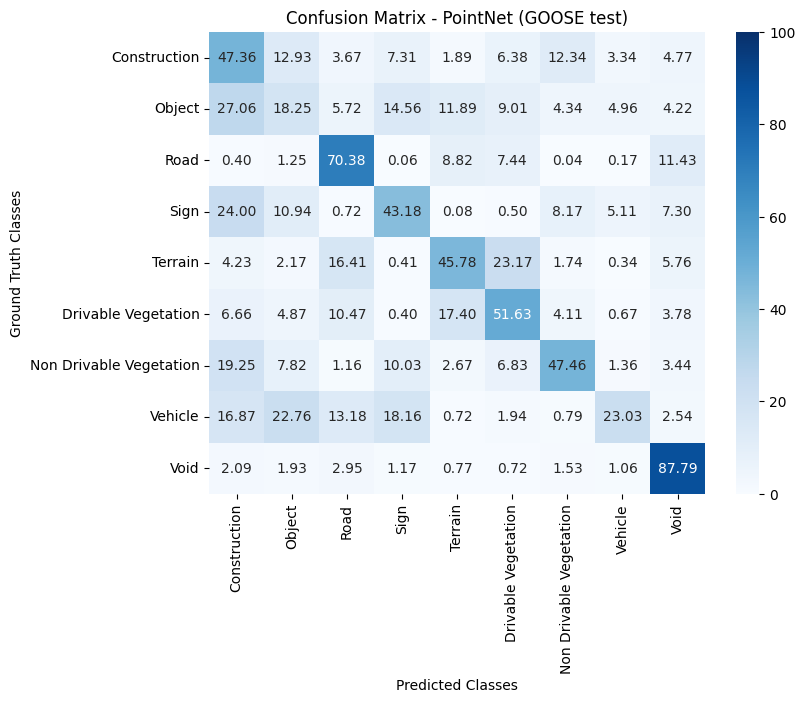

In [17]:
plot_confusion_matrix_percentage(all_labels, all_preds, num_classes=NUM_CLASSES)
